# LA Sanitiation Department 311 Analysis

This notebook provides some basic analysis and visualizations of 311 data.  The focus is on 'Bulky Items' request serviced by the LA Sanitation Dept (LASAN), but the data and techniques can be used for others as well.  

I'll start with some basic notes on the data and analysis that follows:

  1. The 311 data is from data.lacity.org.  The 311 data are points.  I want to publish this as a binder, so I'm using a subset of the columns to minimize the size.  I have to keep it under 50MB.  I did a conversion process from csv -> geodataframe -> parquet files.  Parquet files seem to be the way to go - very fast and efficient.
  2. I'm also using Neighborhood Council polygons from data.lacity.org
  3. I have included three types of visualization - basic bar charts, choropleth maps, and an animated heat map.  The bar charts are used for basic summary stats.
  4.  For the map visualizations I'm using folium.
  5. I build two different choropleths.  The first uses counts of the selected request type.  The second choropleth is the density of counts.  I do a simple computation from the polygon geometries to get to count / square mile.
  6. The final visualization is an animated heat map for a selected Neighborhood Council.  The timeline is for the whole year.
  
**Note:** I've moved some of the support functions to src/lasan.py.  I created an example of a simple class for the animation and a function for the choropleth.  The code is not elegant, it's just meant to show the possiblities.

I'll start with the imports.  Note I'm importing the code from src/lasan.py here.

In [1]:
import pandas as pd
import geopandas as gpd

from ipywidgets import Output, HBox, interactive

from collections import defaultdict, OrderedDict

import sys
sys.path.append('../src')

from lasan import AnimatedMap, nc_choropleth

# Data

I processed the data and transformed to parquet files.  They seem to be quite efficient and fast.

This section covers the two sources used:

1. The 311 data is a subset of the entire 2021 data.  After I read it, I show a couple of summary charts/statistics.  Finally I create a specific subset for Bulky Items.  **Note:** Now we may need to focus on Illegal Dumping?  Will need to refactor a bit so it can be parameterized for the choropleths.
2. The Neighorhood Council data is polygon data from data.lacity.org.  I add the 311 counts per NC for the first choropleth.  After that I use polygon information to compute square miles for the NC and use that for the density.

## Start with the 311 requests.

In [2]:
%%time
thin_gdf = gpd.read_parquet('../data/thin2.parq')

CPU times: user 1.08 s, sys: 280 ms, total: 1.36 s
Wall time: 827 ms


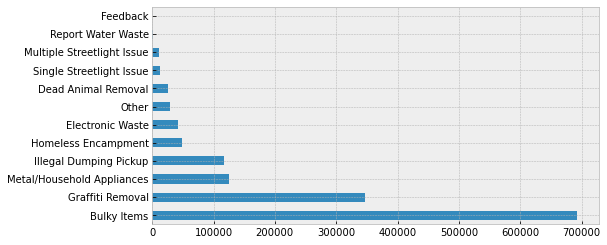

In [3]:
thin_gdf.request_type.value_counts().plot.barh(figsize=(8, 4));

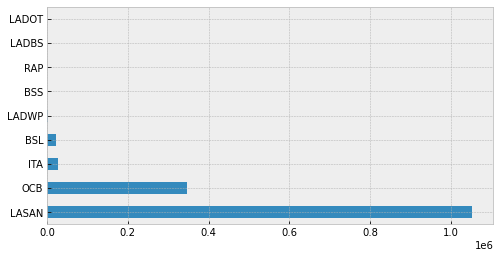

In [4]:
thin_gdf.owner.value_counts().plot.barh(figsize=(8, 4));

Now we can build the subset for bulky items.  We can paramterize here for "selectable" request types in the future.

In [5]:
bulky_items_gdf = thin_gdf.query(f"request_type == 'Bulky Items'").reset_index().drop(columns=['index'])

Could plot this, but here's the top five NC's for Bulky Items request type.

In [6]:
bulky_items_gdf.nc_name.value_counts()[:10]

Van Nuys                          15634
Empowerment Congress Southeast    15619
Sylmar                            15151
Reseda                            13751
Boyle Heights                     13274
Wilshire Center Koreatown         12910
Sherman Oaks                      12854
Woodland Hills-Warner Center      12382
NoHo                              11938
Pacoima                           11864
Name: nc_name, dtype: int64

## Neighborhood Council data

 - Read the data
 - Add counts to polygons

In [7]:
neighborhoods_gdf = gpd.read_parquet('../data/nc.parq')

bulky_items_counts = bulky_items_gdf['nc'].value_counts().to_frame().reset_index().rename(columns={'index': 'nc_id', 'nc': 'count'})

bulky_items_merged_gdf = pd.merge(neighborhoods_gdf, bulky_items_counts, how="left", on=["nc_id"])

bulky_items_gdf['day'] = bulky_items_gdf['created_dt'].apply(lambda dt: dt.date().strftime("%m-%d (%A)"))

  - Compute square miles for the polygon
  - Add the density property to the NC

In [8]:
from pyproj import Geod

geod = Geod(ellps="WGS84")

def square_miles(geo):
    square_meters = abs(geod.geometry_area_perimeter(geo)[0])
    return (square_meters * 10.764) / 27878000

bulky_items_merged_gdf['sq_miles'] = bulky_items_merged_gdf.apply(lambda row: square_miles(row.geometry), axis=1)

bulky_items_merged_gdf['density'] = bulky_items_merged_gdf.apply(lambda row: round((row['count'] / row['sq_miles']), 2) , axis=1)

# Choropleths

I've created the following choropleth maps:

  1. Counts - count for 2021
  2. Density - count per square mile, 2021
  3. Side-by-side comparison

## Count choropleth

In [9]:
choropleth_map = nc_choropleth(bulky_items_merged_gdf, "count", ['nc_id','count'])
choropleth_map

## Density choropleth

In [10]:
density_choropleth_map = nc_choropleth(bulky_items_merged_gdf, "density", ['nc_id','density'])
density_choropleth_map

I just added a density column to the gdf.  We can use that for a new choropleth.  The results are interesting if not predictable.

Here's a slight digression, but I want to understand how the NC's rank when we consider density.  

This is a bit hacky?

In [11]:
df = bulky_items_merged_gdf.sort_values('density', ascending=False).groupby('name').head(5).reset_index().drop(columns=['OBJECTID'])

In [12]:
df[['name', 'density']].head(10)

,name,density
0,WILSHIRE CENTER - KOREATOWN NC,5365.06
1,EAST HOLLYWOOD NC,5284.66
2,WESTLAKE NORTH NC,4560.48
3,MACARTHUR PARK NC,4464.27
4,VOICES OF 90037,4450.87
5,PALMS NC,4444.40
6,ZAPATA KING NC,4280.90
7,UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...,4231.23
8,EMPOWERMENT CONGRESS CENTRAL AREA NDC,4101.56
9,RAMPART VILLAGE NC,3949.63


In [13]:
df['name'][:10].to_list()

['WILSHIRE CENTER - KOREATOWN NC',
 'EAST HOLLYWOOD NC',
 'WESTLAKE NORTH NC',
 'MACARTHUR PARK NC',
 'VOICES OF 90037',
 'PALMS NC',
 'ZAPATA KING NC',
 'UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON HEIGHTS, WEST ADAMS, AND JEFFERSON PARK COMMUNITY',
 'EMPOWERMENT CONGRESS CENTRAL AREA NDC',
 'RAMPART VILLAGE NC']

No overlap?  Hummmm.

What I want to do is compare the two choropleths.  I could scroll up and down, break out the two output cells or ...

Why don't we use two output widgets to look at them side by side!

**Note:** At the end of the day maybe this is the only viz I need?

**Note2:** The case for NC's is different in the two data sets - Ugghh.  Should be fixed, but ...

## Side-by-side chorpoleth comparison

In [14]:
count_output = Output(layout={'border': '1px solid black',
                            'width': '50%'})

density_output = Output(layout={'border': '1px solid black',
                            'width': '50%'})

with count_output:
    display(choropleth_map)

with density_output:
    display(density_choropleth_map)

HBox([count_output, density_output])

# Animated Heat Map

The final map visualization.  

  1. The 311 calls have be entended with day of the week for the timeline.
  2. The NC polygons provide context and map navigation.
  
Pretty basic use of the HeatMapWithTime plugin from folium

In [15]:
neighborhoods_gdf.columns

Index(['OBJECTID', 'name', 'WADDRESS', 'DWEBSITE', 'DEMAIL', 'DPHONE', 'nc_id',
       'CERTIFIED', 'TOOLTIP', 'NLA_URL', 'service_region', 'region_id',
       'color_code', 'geometry'],
      dtype='object')

I've wrapped the display in the interactive widget.  The pick list is sorted by count.

In [16]:
an_map = AnimatedMap(observations=bulky_items_gdf, boundaries=neighborhoods_gdf)

def silly(nc_name):
    an_map.nc(nc_name)
    display(an_map.nc_hmap)

w = interactive(silly, nc_name=bulky_items_merged_gdf.sort_values(by=['count'], ascending=False).name.to_list())

w

interactive(children=(Dropdown(description='nc_name', options=('VAN NUYS NC', 'EMPOWERMENT CONGRESS SOUTHEAST …